In [5]:
import numpy as np
import torch as th
# from utilities import *
from force_engine import *
from matplotlib import pyplot as plt
from time import time as get_time
from AIGLE import GLESimulator, LESimulator
from AIGLE import AIGLE
from AIGLE.utilities import *

np.set_printoptions(precision=4)
dev = 'cuda' if th.cuda.is_available() else 'cpu'
def mic(x):
    return (x+np.pi) % (2*np.pi) - np.pi

def mfpt(traj, start, end, epsilon = 0.05):
    def d(a,b):
        if type(a) is np.ndarray or th.tensor:
            return ((a-b)**2).sum()**0.5
        else:
            return np.abs(a-b)
    start_list = []
    fpt_list = []
    end_list = []
    for idx, x in enumerate(traj):
        if d(x, start) < epsilon:
            start_list.append( idx * 1 )
        if len(start_list) > 0 and d(x, end) < epsilon:
            fpt = idx - np.array(start_list)
            fpt_list.append(fpt)
            start_list = []
            end_list.append(idx * 1 )
    fpt_list = np.concatenate(fpt_list)
    return np.array(end_list), fpt_list



In [3]:
## load mass and constraint
eigM = np.array([
        [ 0.5287,  0.8488],
        [ 0.8488, -0.5287]
])
eigM = np2th(eigM)
def get_constraint(transform):
    def position_constraint(rxy):
        _rxy = rxy.reshape(1,-1) @ transform.T
        _cv0_old = _rxy[0,0]*1.0
        _rxy[0,0] = th.clamp(_rxy[0,0], min=-np.pi-0.24, max=1.6)
        if th.abs(_rxy[0,0]-_cv0_old)>0.1:
            print("before clamp {}, after {}".format(_cv0_old, _rxy[0,0]))
        # _rxy[0,0] = th.clamp(_rxy[0,0], min=-np.pi-0.24, max=1.6)
        return (_rxy @ transform).flatten()
    return position_constraint

position_constraint = get_constraint(eigM)
position_constraint = None

## load force field (fourier)

In [ ]:

# load free energy parameters
fes_coef_cos = np.load('alanine_depeptide/GLE_data/fes_fourier_coef_cos.npy' )
fes_coef_sin = np.load('alanine_depeptide/GLE_data/fes_fourier_coef_sin.npy' )
fes_freq = np.load('alanine_depeptide/GLE_data/fes_fourier_freq.npy' )

fes_coef_cos = np2th(fes_coef_cos)
fes_coef_sin = np2th(fes_coef_sin)
fes_freq = np2th(fes_freq)

def get_fes_func(cosw_coef, sinw_coef, kxy, transform):
    def fes_func(rxy):
        nd = rxy.shape[-1]
        _rxy = rxy.reshape(-1,nd) @ transform.T
        _rxy = _rxy.reshape(rxy.shape)
        return fourier_nd_potential( cosw_coef, sinw_coef, kxy, _rxy ).flatten()
    return fes_func

def get_force_func(cosw_coef, sinw_coef, kxy, transform):
    def force_func(rxy):
        nd = rxy.shape[-1]
        _rxy = rxy.reshape(-1,nd) @ transform.T
        _rxy = _rxy.reshape(rxy.shape)
        _force = fourier_nd_force( cosw_coef, sinw_coef, kxy, _rxy )
        force = _force.reshape(-1,nd) @ transform
        return force.flatten() 
    return force_func



calc_fes = get_fes_func(fes_coef_cos, fes_coef_sin, fes_freq, eigM)  ## in unit of kbT
force_engine = get_force_func(fes_coef_cos, fes_coef_sin, fes_freq, eigM)  # in unit of kbT/nm

xb = [- np.pi, np.pi]
yb = [- np.pi+1, np.pi+1]
nbins = [120, 100]
vmin, vmax = (0,12)
level_set = np.linspace(vmin,vmax,10)
# level_set = [1,10]
xbin = np.linspace(xb[0], xb[1], nbins[0])
ybin = np.linspace(yb[0], yb[1], nbins[1])
xx, yy = np.meshgrid(xbin, ybin, indexing='ij')
xx,yy = np2th(xx), np2th(yy)
rxy = th.stack([xx.flatten(), yy.flatten()]).transpose(1,0)
fes = th2np(calc_fes(rxy)).reshape(xx.shape)


fig, ax = plt.subplots(1,1, figsize=(8,6))
im = ax.imshow(fes.T, vmin=vmin, vmax=vmax, #alpha=alphas.T,
               aspect='equal', origin='lower', extent=xb+yb)
_cs = ax.contour(fes.T, levels=level_set , linewidths=1, origin='lower', extent=xb+yb)
cbar = fig.colorbar(im, ax=ax)
cbar.add_lines(_cs)
 

## load FES (intepolation)

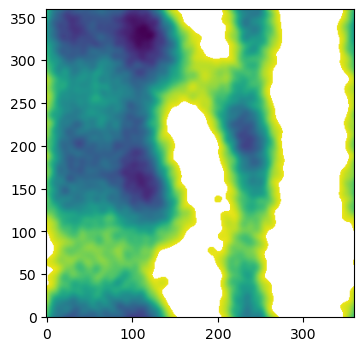

In [4]:
kbT2kjmol = 2.479
free_energy = np.load('./alanine_depeptide/free_energy.npy') #kJ/mol
free_energy -= free_energy.min()
free_energy /= kbT2kjmol  # in unit of kbT
free_energy = free_energy.T

def interpolate(m, shift):
    shift_x, shift_y = shift
    y0 = (1-shift_x) * m[0, 0] + shift_x * m[1,0]
    y1 = (1-shift_x) * m[0, 1] + shift_x * m[1,1]
    result = (1-shift_y)* y0 + shift_y * y1
    return result
 
def get_energy_func(free_energy_table):
    fes = free_energy_table
    nx, ny = fes.shape
    ## the free energy repeats
    nx -= 1 
    ny -= 1
    def interpolated_energy(phi_psi):
        rxy = (phi_psi+np.pi) / (2*np.pi)
        rxy = rxy - np.floor(rxy)
        rxy = rxy 
        lx = rxy[0] * nx
        ly = rxy[1] * ny   ## relative location between 0 and nx/ny

        base_idx_x = int(np.floor(lx)) % nx 
        base_idx_y = int(np.floor(ly)) % ny
        next_idx_x = (base_idx_x+1) % nx
        next_idx_y = (base_idx_y+1) % ny

        m = np.array([
            [fes[base_idx_x, base_idx_y], fes[base_idx_x, next_idx_y]],
            [fes[next_idx_x, base_idx_y], fes[next_idx_x, next_idx_y]]
        ])

        energy = interpolate(m, shift=[lx - base_idx_x, ly - base_idx_y])
        return energy
    return interpolated_energy


def get_force_func(free_energy, dx, dy):
    fes_gradx = ( np.roll(free_energy[:-1,:-1],-1,0) - np.roll(free_energy[:-1,:-1], 1, 0 )) / 2 / dx
    fes_grady = ( np.roll(free_energy[:-1,:-1],-1,1) - np.roll(free_energy[:-1,:-1], 1, 1 )) / 2 / dy    
    nx, ny = fes_gradx.shape
    def interpolated_force(phi_psi):
        rxy = (phi_psi+np.pi) / (2*np.pi)
        rxy = rxy - np.floor(rxy)
        rxy = rxy 
        lx = rxy[0] * nx
        ly = rxy[1] * ny   ## relative location between 0 and nx/ny

        base_idx_x = int(np.floor(lx)) % nx 
        base_idx_y = int(np.floor(ly)) % ny
        next_idx_x = (base_idx_x+1) % nx
        next_idx_y = (base_idx_y+1) % ny

        m = np.array([
            [fes_gradx[base_idx_x, base_idx_y], fes_gradx[base_idx_x, next_idx_y]],
            [fes_gradx[next_idx_x, base_idx_y], fes_gradx[next_idx_x, next_idx_y]]
        ])

        grad_x = interpolate(m, shift=[lx - base_idx_x, ly - base_idx_y])

        m = np.array([
            [fes_grady[base_idx_x, base_idx_y], fes_grady[base_idx_x, next_idx_y]],
            [fes_grady[next_idx_x, base_idx_y], fes_grady[next_idx_x, next_idx_y]]
        ])

        grad_y = interpolate(m, shift=[lx - base_idx_x, ly - base_idx_y])
        force = - np.array([grad_x, grad_y])
        return force
    return interpolated_force

def get_energy_func_torch(energy_func_np, transform):
    def energy_func_th(rxy):
        _rxy =  rxy.reshape(1,2) @ transform.T
        _rxy = th2np(_rxy).flatten()
        energy = energy_func_np(_rxy)
        return energy
    return energy_func_th

def get_force_func_torch(force_func_np, transform):
    def force_func_th(rxy):
        _rxy =  rxy.reshape(1,2) @ transform.T
        _rxy = th2np(_rxy).flatten()
        _force = force_func_np(_rxy)
        force = np2th(_force).reshape(1,2) @ transform
        return force.reshape(rxy.shape)
    return force_func_th


dx = 2 * np.pi / (free_energy.shape[0]-1)
dy = 2 * np.pi / (free_energy.shape[1]-1)
force_func_np = get_force_func(free_energy, dx, dy)
force_engine = get_force_func_torch(force_func_np, eigM)
energy_func_np = get_energy_func(free_energy )
energy_engine = get_energy_func_torch(energy_func_np, eigM)

###
energy_upper_bound = 12
maxe_filter = (free_energy > energy_upper_bound).astype(float)
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.imshow(free_energy.T,origin='lower', alpha=1-maxe_filter.T)


# simulate GLE

In [8]:
## load GLE configurations
import json
with open('alanine_depeptide/GLE_data/cv_fitdr2_fit50ps.json',) as f:
    gle_config = json.load(f) 
    
## setup systems
temp = gle_config['temp'] # K
kbT = 1 # in unit of abs kbT
v2avg = np.array(gle_config['average_v2']) # (rad/ps)**2
mass = kbT / v2avg  ## kbT / (nm/ns)**2
dt = 0.0025  #ps
x0 = np.array([-1,-1])
print('mass=', mass)
print('v2avg=', v2avg)


## set up simulator
simulation = GLESimulator(gle_config, timestep=dt, ndim=2, mass = mass)
simulation.set_force_engine(force_engine)
simulation.set_energy_engine(energy_engine)
simulation.set_constraint(position_constraint)
# simulation.set_constraint(None)
simulation.set_position(x0)

# simulation.step(20000)
log_freq = 40
DT = dt * log_freq

mass= [0.0209 0.0104]
v2avg= [47.9004 95.7566]


In [8]:
temp_list = []
x_list = []
v_list = []
r_list = []
# relax
nrelax = int(10 / dt) # relax 10ps
simulation.step(nrelax, energy_upper_bound)
## simulation
tot_time = 60 ## ns
nreps = int(tot_time * 1000 / DT)
t0=get_time()
for idx in range(nreps):
    simulation.step(log_freq, energy_upper_bound)
    ins_temp = simulation.get_instant_temp() 
    temp_list.append(th2np(ins_temp))
    x_list.append(th2np(simulation.x).copy())
    v_list.append(th2np(simulation.v).copy())
    # r_list.append(th2np(simulation.noise_tot).copy())
    
    if idx % int(nreps//50) == 0:
        wtime = get_time()-t0
        print('t={:.2f}ns, temp={}K, x={}nm, v={}rad/ps, wall time {:.2f}s'.format(
            simulation._step * dt/1000, th2np(ins_temp), th2np(simulation.x.reshape(1,2) @ eigM.T), th2np(simulation.v), wtime))
x_list = np.array(x_list)
v_list = np.array(v_list)
np.save('alanine_depeptide/GLE_data/gle_traj_DT100fs_fit2ps', x_list)

print('Done!')
avg_temp = np.array(temp_list).mean(0)
print('average temp=', avg_temp, 'K')

t=0.01ns, temp=[5.875  9.0407]K, x=[[-1.2713 -0.4213]]nm, v=[ 0.9685 -1.6987]rad/ps, wall time 0.01s
t=1.21ns, temp=[123.0428 289.5962]K, x=[[-0.8499 -0.5348]]nm, v=[ 4.4324 -9.6144]rad/ps, wall time 176.91s
t=2.41ns, temp=[251.7954 133.5842]K, x=[[-1.7255  3.1587]]nm, v=[-6.3406  6.5298]rad/ps, wall time 358.28s
t=3.61ns, temp=[  0.6415 490.5643]K, x=[[-1.1264 -3.6801]]nm, v=[ -0.32   -12.5133]rad/ps, wall time 539.22s
t=4.81ns, temp=[2.2052e-01 1.7612e+03]K, x=[[-1.2261 -3.9551]]nm, v=[ 0.1876 23.7101]rad/ps, wall time 709.32s
t=6.01ns, temp=[939.0615  13.4739]K, x=[[-2.0627 -6.2039]]nm, v=[12.2449 -2.0738]rad/ps, wall time 879.59s
t=7.21ns, temp=[112.8968 129.8807]K, x=[[-1.1812 -6.6308]]nm, v=[-4.2457  6.4387]rad/ps, wall time 1049.93s
t=8.41ns, temp=[  1.24   101.2368]K, x=[[-1.269  -3.7648]]nm, v=[-0.445  -5.6845]rad/ps, wall time 1219.58s
t=9.61ns, temp=[132.896  586.2316]K, x=[[-1.101  -3.7843]]nm, v=[  4.6064 -13.6791]rad/ps, wall time 1389.24s
t=10.81ns, temp=[ 16.4093 391.03

## visualize trajectory / diffusion analysis

(-35.0, 35.0)

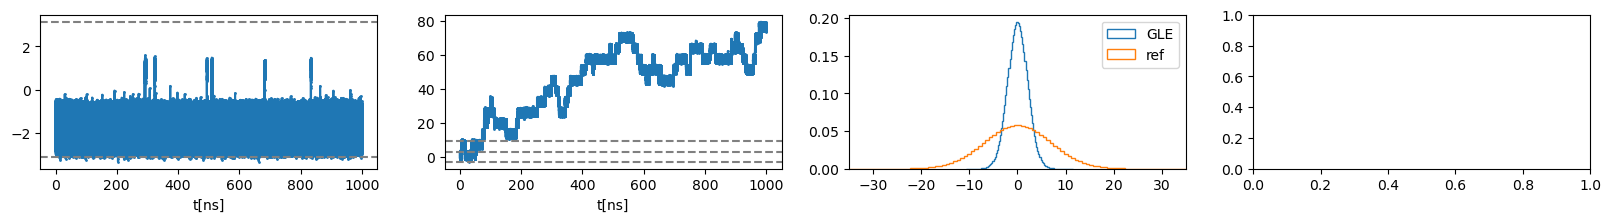

In [9]:
x_list= np.load('alanine_depeptide/GLE_data/gle_traj_DT100fs_fit50ps.npy')
v_list = (x_list[1:]-x_list[:-1])/DT

nframes, ndim = x_list.shape
plot_x =  x_list @ th2np(eigM.T)
plot_t = np.arange(plot_x.shape[0]) * DT / 1000

fig, ax = plt.subplots(1,4,figsize=(20,2))
ax[0].plot(plot_t[::10],  plot_x[::10,0], marker='o', markersize=1)
ax[0].set_xlabel('t[ns]')
ax[1].plot(plot_t[::10],  plot_x[::10,1], marker='o', markersize=1)
ax[1].set_xlabel('t[ns]')
    
ax[2].hist(v_list[:,0], 100, density=True, histtype='step', label='GLE')
ref_v_dist = np.random.normal(0, v2avg[0]**0.5, nframes)
ax[2].hist(ref_v_dist, 100, density=True, histtype='step',label='ref')

ax[0].axhline(np.pi, color='grey', linestyle='dashed')
ax[0].axhline(-np.pi, color='grey', linestyle='dashed')
ax[1].axhline(np.pi, color='grey', linestyle='dashed')
ax[1].axhline(3*np.pi, color='grey', linestyle='dashed')
ax[1].axhline(-np.pi, color='grey', linestyle='dashed')

ax[2].legend()
ax[2].set_xlim(-35,35)
 

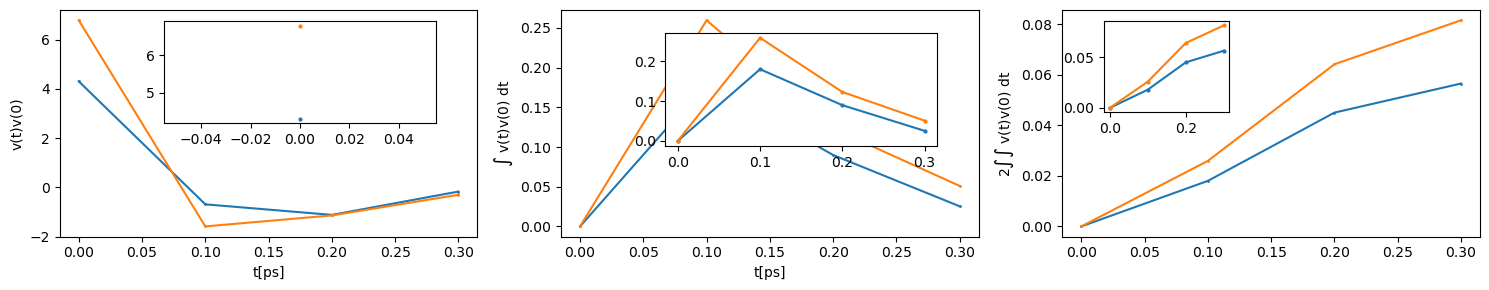

In [6]:
## velocity auto-correlation
ncorr = int(0.4 / DT)
corr_t = np.arange(ncorr) * DT  # ns
cv_v = np2th(v_list)
corr_vtv0 = Corr_t(cv_v, cv_v, ncorr)
int1_vtv0 = th.cumsum( (corr_vtv0[1:]+corr_vtv0[:-1])/2, 0) * DT
int1_vtv0 = th.cat([th.zeros_like(int1_vtv0[0]).reshape(1,2), int1_vtv0], 0)
int2_vtv0 = th.cumsum( (int1_vtv0[1:]+int1_vtv0[:-1])/2, 0) * DT
int2_vtv0 = th.cat([th.zeros_like(int2_vtv0[0]).reshape(1,2), int2_vtv0], 0)


fig, ax = plt.subplots(1,3, figsize=(15,3))
 
axins0 = ax[0].inset_axes([0.25, 0.5, 0.65, 0.45])
axins1 = ax[1].inset_axes([0.25, 0.4, 0.65, 0.5])
axins2 = ax[2].inset_axes([0.1, 0.55, 0.3, 0.4])
for i in range(ndim):
    ax[0].plot(corr_t , th2np(corr_vtv0)[:,i] , marker='o', markersize=1)
    axins0.plot(corr_t[:int(0.1/DT)]  , th2np(corr_vtv0)[:int(0.1/DT),i], marker='o', markersize=2)

    ax[1].plot(corr_t[:10000], th2np(int1_vtv0[:10000,i]), marker='o', markersize=1)
    axins1.plot(corr_t[:int(0.4/DT)]  , th2np(int1_vtv0[:,i])[:int(0.4/DT)], marker='o', markersize=2)
    # ax[1].set_ylim(-0.01, 0.05)
    
    ax[2].plot(corr_t, 2*th2np(int2_vtv0[:,i]), marker='o', markersize=1)
    axins2.plot(corr_t[:100]  , 2*th2np(int2_vtv0[:,i])[:100], marker='o', markersize=2)
    

ax[0].set_xlabel('t[ps]')
ax[1].set_xlabel('t[ps]')
ax[0].set_ylabel('v(t)v(0)')
ax[1].set_ylabel('$\int$ v(t)v(0) dt')
ax[2].set_ylabel('2$\int\int$ v(t)v(0) dt')

 
plt.tight_layout()

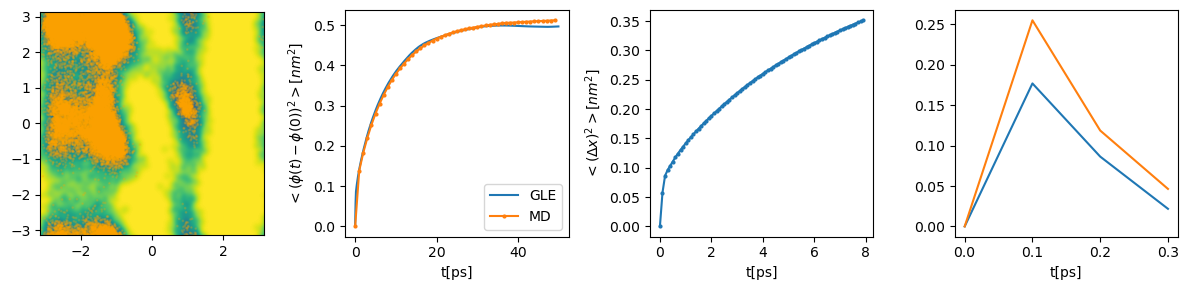

In [15]:
### results of fit dr2/dt
# x_list = np.load('alanine_depeptide/GLE_data/gle_traj_dt4fs_fitdr2.npy')
# v_list = (x_list[1:] - x_list[:-1])/DT
########## MD diffusion
md_r2_t = np.arange(75)
md_r2=np.array([0.    , 0.1385, 0.1836, 0.2204, 0.2526, 0.2805, 0.3049, 0.3268,
       0.3462, 0.3637, 0.379 , 0.3925, 0.4047, 0.4158, 0.4259, 0.4348,
       0.4425, 0.4498, 0.4558, 0.4618, 0.4669, 0.4711, 0.4751, 0.4788,
       0.482 , 0.4852, 0.4878, 0.4901, 0.4926, 0.4941, 0.4961, 0.4977,
       0.4993, 0.5009, 0.5023, 0.5031, 0.5048, 0.5059, 0.5062, 0.5067,
       0.5074, 0.5079, 0.5086, 0.5092, 0.5097, 0.5102, 0.5106, 0.5111,
       0.5117, 0.5122, 0.5128, 0.5132, 0.5134, 0.5139, 0.5139, 0.514 ,
       0.5142, 0.5145, 0.5147, 0.5145, 0.5146, 0.5142, 0.5139, 0.5143,
       0.5144, 0.5144, 0.5146, 0.5145, 0.5147, 0.5148, 0.5153, 0.5157,
       0.5155, 0.5154, 0.515 ])
###########  FES
xb = [-np.pi, np.pi]
yb = [-np.pi, np.pi]
kbT2kjmol = 2.479
free_energy = np.load('./alanine_depeptide/free_energy.npy') #kJ/mol
free_energy -= free_energy.min()
free_energy /= kbT2kjmol  # in unit of kbT
free_energy = free_energy.T
vmin, vmax = (0,free_energy.max()-0.0004)

###########  diffusion
# r2 = [np.zeros_like(x_list[0])]
# n=int(400/DT)
# for idx in range(1,n):
#     r2.append(((x_list[idx:] - x_list[:-idx])**2).mean(0))
# r2 = np.array(r2)
x_main = (x_list @ th2np(eigM.T))[:,0]
r2 = [0]
n=int(50/DT)
for idx in range(1,n):
    r2.append(((x_main[idx:] - x_main[:-idx])**2).mean())
r2 = np.array(r2)
########### velocity auto-correlation
ncorrvv = int(0.4/DT)
corr_vtv0 = Corr_t(v_list, v_list, ncorrvv)
int1_vtv0 = np.cumsum( (corr_vtv0[1:]+corr_vtv0[:-1])/2, 0) * DT
int1_vtv0 = np.concatenate([np.zeros_like(int1_vtv0[0]).reshape(1,2), int1_vtv0], 0)
###########  plot
fig,ax = plt.subplots(1,4, figsize=(12,3))
im = ax[0].imshow( free_energy.T, vmin=vmin, vmax=vmax, aspect='equal', origin='lower', extent=xb+yb)
ax[0].scatter(mic(plot_x)[::100 ,0], mic(plot_x)[::100 ,1], np.ones_like(plot_x[::100 ,1]), alpha=0.2, color='orange')
nn = int(8/DT)
for idx in range(ndim):
#     ax[1].plot(np.arange(n)*DT, r2[:,idx])
#     ax[2].plot(np.arange(nn)*DT, r2[:nn,idx], marker='o', markersize=2)
#     ax[2].plot(np.arange(3)*DT, v2avg[idx] * (np.arange(3)*DT)**2, linestyle='dashed' )
    ax[3].plot(np.arange(ncorrvv)*DT, int1_vtv0[:,idx] )
ax[1].plot(np.arange(n)*DT, r2 , label='GLE')
ax[2].plot(np.arange(nn)*DT, r2[:nn], marker='o', markersize=2)
ax[1].plot(md_r2_t[md_r2_t<50], md_r2[md_r2_t<50], marker='o', markersize=2, label='MD')

ax[1].set_xlabel('t[ps]')
ax[1].set_ylabel('$<(\phi(t)-\phi(0))^2>$[$nm^2$]')
ax[1].legend()
ax[2].set_xlabel('t[ps]')
ax[2].set_ylabel('$<(\Delta x)^2>$[$nm^2$]')
ax[3].set_xlabel('t[ps]')

plt.tight_layout()

# simulate LE

/scratch/gpfs/pinchenx/AIGLE_continuous/AIGLE/utilities.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return th.tensor(x, dtype=th.float, device=dev)


Langevin friction: tensor([8.4628e+02, 3.1975e-01])
t=0.01ns, temp=497.27374267578125K, x=[[-1.0996 -0.3468]]nm, v=[  7.5208 -14.296 ]rad/ps, wall time 0.01s
t=0.21ns, temp=146.6629638671875K, x=[[-1.3811  2.4157]]nm, v=[6.1528 4.2365]rad/ps, wall time 10.59s
t=0.41ns, temp=654.8320922851562K, x=[[-2.6731  3.1037]]nm, v=[ 5.6244 18.8359]rad/ps, wall time 21.35s
t=0.61ns, temp=14.058670043945312K, x=[[-1.3199  2.984 ]]nm, v=[ 0.836  -2.7527]rad/ps, wall time 32.18s
t=0.81ns, temp=24.352447509765625K, x=[[-1.0315 -0.1421]]nm, v=[ 0.0409 -3.9424]rad/ps, wall time 43.01s
t=1.01ns, temp=172.5609893798828K, x=[[-1.3029  1.7172]]nm, v=[3.8521 8.9719]rad/ps, wall time 53.75s
t=1.21ns, temp=192.152099609375K, x=[[-1.3115  2.5642]]nm, v=[ -1.5336 -10.8611]rad/ps, wall time 64.62s
t=1.41ns, temp=131.32640075683594K, x=[[-1.2699  2.5711]]nm, v=[-6.417   1.2325]rad/ps, wall time 75.34s
t=1.61ns, temp=282.2938232421875K, x=[[-1.4308  2.4787]]nm, v=[-2.9435 12.7628]rad/ps, wall time 86.13s
t=1.81ns, 

(-25.0, 25.0)

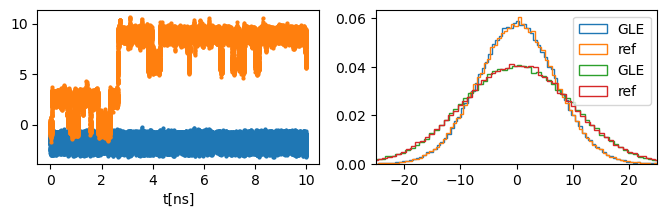

In [5]:
# manuall specify tau
# le_simulation = LESimulator(temp,np2th(np.ones(2)), dt, ndim=2, mass=simulation.mass.clone().detach())
# le_simulation.set_force_engine(force_engine)
# le_simulation.set_constraint(position_constraint)
# 
le_simulation = simulation.get_langevin_integrator(dt)
print('Langevin friction:', le_simulation.friction)
le_simulation.set_position(x0)
le_temp_list = []
le_x_list = []
le_v_list = []

log_freq = 40
DT = dt * log_freq
## relax
nrelax = int(10 / dt) # relax 10ps
le_simulation.step(nrelax, energy_upper_bound)
## simulation
tot_time = 10 ## ns
nreps = int(tot_time * 1000 / DT)
t0=get_time()
for idx in range(nreps):
    le_simulation.step(log_freq, energy_upper_bound)
    ins_temp = le_simulation.get_instant_temp()
    le_temp_list.append(th2np(ins_temp).copy())
    le_x_list.append(th2np(le_simulation.x).copy())
    le_v_list.append(th2np(le_simulation.v).copy())
    if idx % int(nreps//50) == 0: 
        wtime = get_time()-t0
        print('t={:.2f}ns, temp={}K, x={}nm, v={}rad/ps, wall time {:.2f}s'.format(
            le_simulation._step * dt/1000, th2np(ins_temp), th2np(le_simulation.x.reshape(1,2) @ eigM.T), th2np(le_simulation.v), wtime))
np.save('alanine_depeptide/GLE_data/le_traj_dt4fs_fitdr2', np.array(le_x_list))
        
le_x_list = np.array(le_x_list)
le_v_list = np.array(le_v_list)
avg_temp = np.array(le_temp_list).mean(0)
print('average temp=', avg_temp, 'K')


(-35.0, 35.0)

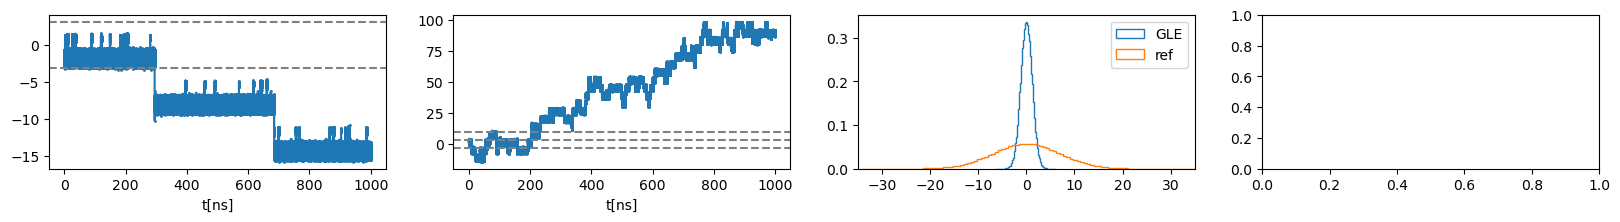

In [16]:
le_x_list= np.load('alanine_depeptide/GLE_data/le_traj_DT100fs_fit50ps.npy') 
le_v_list = (le_x_list[1:] - le_x_list[:-1])/DT
nframes, ndim = le_x_list.shape
plot_x =  le_x_list @ th2np(eigM.T)
plot_t = np.arange(plot_x.shape[0]) * DT / 1000

fig, ax = plt.subplots(1,4,figsize=(20,2))
ax[0].plot(plot_t[::10],  plot_x[::10,0], marker='o', markersize=1)
ax[0].set_xlabel('t[ns]')
ax[1].plot(plot_t[::10],  plot_x[::10,1], marker='o', markersize=1)
ax[1].set_xlabel('t[ns]')
    
ax[2].hist(le_v_list[:,0], 100, density=True, histtype='step', label='GLE')
ref_v_dist = np.random.normal(0, v2avg[0]**0.5, nframes)
ax[2].hist(ref_v_dist, 100, density=True, histtype='step',label='ref')

ax[0].axhline(np.pi, color='grey', linestyle='dashed')
ax[0].axhline(-np.pi, color='grey', linestyle='dashed')
ax[1].axhline(np.pi, color='grey', linestyle='dashed')
ax[1].axhline(3*np.pi, color='grey', linestyle='dashed')
ax[1].axhline(-np.pi, color='grey', linestyle='dashed')

ax[2].legend()
ax[2].set_xlim(-35,35)
 

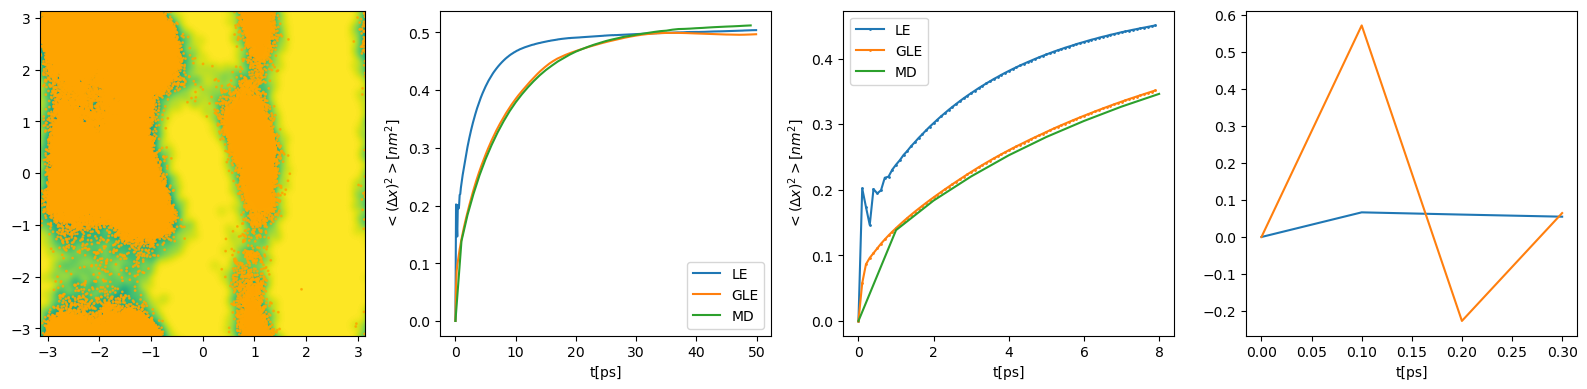

In [17]:

########## MD diffusion
md_r2_t = np.arange(75)
md_r2=np.array([0.    , 0.1385, 0.1836, 0.2204, 0.2526, 0.2805, 0.3049, 0.3268,
       0.3462, 0.3637, 0.379 , 0.3925, 0.4047, 0.4158, 0.4259, 0.4348,
       0.4425, 0.4498, 0.4558, 0.4618, 0.4669, 0.4711, 0.4751, 0.4788,
       0.482 , 0.4852, 0.4878, 0.4901, 0.4926, 0.4941, 0.4961, 0.4977,
       0.4993, 0.5009, 0.5023, 0.5031, 0.5048, 0.5059, 0.5062, 0.5067,
       0.5074, 0.5079, 0.5086, 0.5092, 0.5097, 0.5102, 0.5106, 0.5111,
       0.5117, 0.5122, 0.5128, 0.5132, 0.5134, 0.5139, 0.5139, 0.514 ,
       0.5142, 0.5145, 0.5147, 0.5145, 0.5146, 0.5142, 0.5139, 0.5143,
       0.5144, 0.5144, 0.5146, 0.5145, 0.5147, 0.5148, 0.5153, 0.5157,
       0.5155, 0.5154, 0.515 ])
###########  FES
xb = [-np.pi, np.pi]
yb = [-np.pi, np.pi]
kbT2kjmol = 2.479
free_energy = np.load('./alanine_depeptide/free_energy.npy') #kJ/mol
free_energy -= free_energy.min()
free_energy /= kbT2kjmol  # in unit of kbT
free_energy = free_energy.T
vmin, vmax = (0,free_energy.max()-0.0004)

###########  diffusion
# r2 = [np.zeros_like(le_x_list[0])]
# n=int(200/DT)
# for idx in range(1,n):
#     r2.append(((le_x_list[idx:] - le_x_list[:-idx])**2).mean(0))
# r2 = np.array(r2)
le_x_main = (le_x_list @ th2np(eigM.T))[:,0]
le_r2 = [0]
n=int(50/DT)
for idx in range(1,n):
    le_r2.append(((le_x_main[idx:] - le_x_main[:-idx])**2).mean())
le_r2 = np.array(le_r2)
########### velocity auto-correlation
ncorrvv = int(0.4/DT)
corr_vtv0 = Corr_t(le_v_list, le_v_list, ncorrvv)
int1_vtv0 = np.cumsum( (corr_vtv0[1:]+corr_vtv0[:-1])/2, 0) * DT
int1_vtv0 = np.concatenate([np.zeros_like(int1_vtv0[0]).reshape(1,2), int1_vtv0], 0)
###########  plot
fig,ax = plt.subplots(1,4, figsize=(16,4))
im = ax[0].imshow( free_energy.T, vmin=vmin, vmax=vmax, aspect='equal', origin='lower', extent=xb+yb)
tcut = int(80*1000/DT)
ax[0].scatter(mic(plot_x)[ :tcut ,0], mic(plot_x)[:tcut  ,1], np.ones_like(plot_x[:tcut  ,1]), alpha=0.8, color='orange')
nn = int(8/DT)
for idx in range(ndim):
#     ax[1].plot(np.arange(n)*DT, r2[:,idx])
    # ax[2].plot(np.arange(nn)*DT, r2[:nn,idx], marker='o', markersize=2)
#     ax[2].plot(np.arange(3)*DT, v2avg[idx] * (np.arange(3)*DT)**2, linestyle='dashed' )
    ax[3].plot(np.arange(ncorrvv)*DT, int1_vtv0[:,idx] )
ax[1].plot(np.arange(n)*DT, le_r2, label='LE')
ax[1].plot(np.arange(n)*DT, r2, label='GLE' )
ax[1].plot(md_r2_t[md_r2_t<50], md_r2[md_r2_t<50], label='MD' )

ax[1].legend()
ax[2].plot(np.arange(nn)*DT, le_r2[:nn], marker='o', markersize=1, label='LE')
ax[2].plot(np.arange(nn)*DT, r2[:nn], marker='o', markersize=1, label='GLE')
ax[2].plot(md_r2_t[:9], md_r2[:9], label='MD' )
ax[2].legend()
    
ax[1].set_xlabel('t[ps]')
ax[1].set_ylabel('$<(\Delta x)^2>$[$nm^2$]')
ax[2].set_xlabel('t[ps]')
ax[2].set_ylabel('$<(\Delta x)^2>$[$nm^2$]')
ax[3].set_xlabel('t[ps]')

plt.tight_layout()


## check reproduction of FES

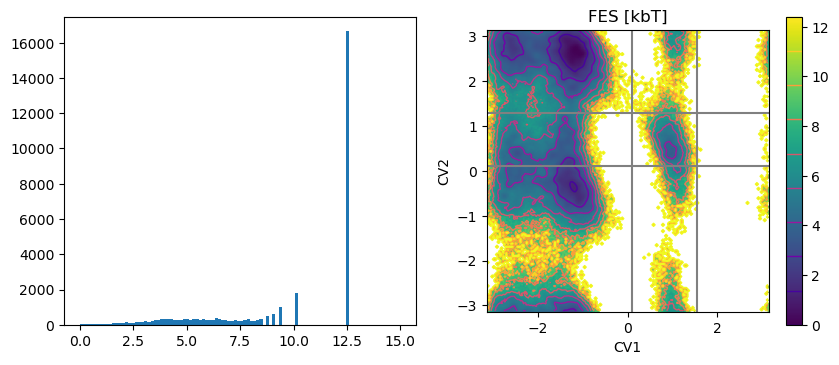

In [19]:
xb = [-np.pi, np.pi]
yb = [-np.pi, np.pi]
nbins = [180, 180]
vmin, vmax = (0,12.4)
level_set = np.linspace(vmin,vmax,10)
cv_x = mic(x_list @ th2np(eigM.T))
height, xedges, yedges, fig = plt.hist2d( cv_x[:,0], cv_x[:,1], bins=nbins, range=[xb, yb])
xbin = (xedges[1:]+xedges[:-1])/2
ybin = (yedges[1:]+yedges[:-1])/2
betaE = -np.log(height+0.1)
betaE -= betaE.min()
plt.close()

alphas= (betaE < vmax).astype(float)
fig,[ax1,ax] = plt.subplots(1,2, figsize=(10,4))
im = ax.imshow( betaE.T, vmin=vmin, vmax=vmax, alpha=alphas.T,
               aspect='equal', origin='lower', extent=xb+yb)
_cs = ax.contour(betaE.T, levels=level_set , cmap='plasma',  linewidths=1,
           origin='lower', extent=xb+yb)
ax1.hist(betaE.flatten(), 100, range=[0,15])

cbar = fig.colorbar(im, ax=ax)
cbar.add_lines(_cs)

# Add labels and title
ax.set_xlabel('CV1')
ax.set_ylabel('CV2')
ax.set_title('FES [kbT]')


ax.axvline(0.1, color='grey')
ax.axhline(0.1, color='grey')
ax.axvline(1.55, color='grey')
ax.axhline(1.3, color='grey')

# calculate MFPT

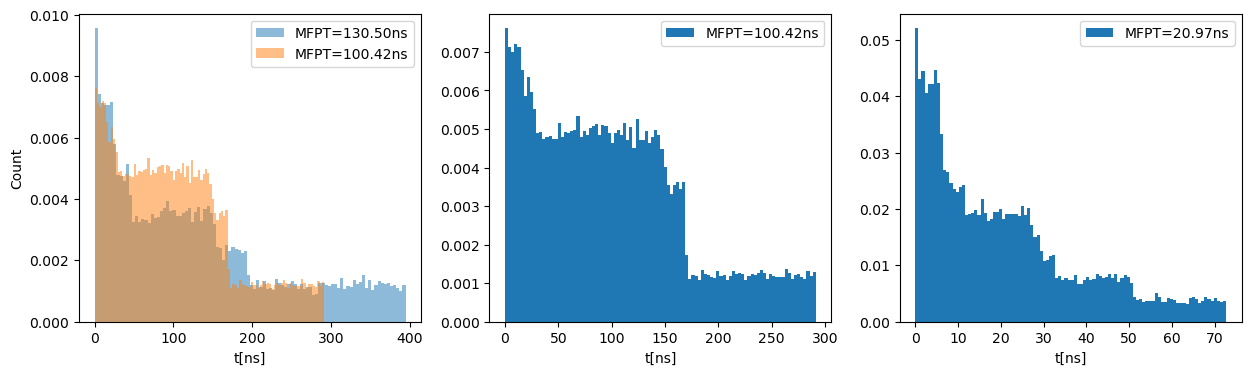

In [60]:
DT = 0.1 # ps
md_DT = 1 
md_x_main = np.load('alanine_depeptide/data/traj_1ps.npy')[:, 0]
x_list= np.load('alanine_depeptide/GLE_data/gle_traj_DT100fs_fit50ps.npy')
gle_x_main =  (x_list @ th2np(eigM.T))[:,0]
le_x_list= np.load('alanine_depeptide/GLE_data/le_traj_DT100fs_fit50ps.npy')
le_x_main =  (le_x_list @ th2np(eigM.T))[:,0]

start = -1.5
end = 1
end_idx, gle_fpt = mfpt(gle_x_main , start, end) 
gle_fpt = gle_fpt.astype(float) * DT / 1000
end_idx, le_fpt = mfpt(le_x_main , start, end) 
le_fpt = le_fpt.astype(float) * DT / 1000
end_idx, md_fpt = mfpt(md_x_main , start, end) 
md_fpt = md_fpt.astype(float) * md_DT / 1000

fig,ax = plt.subplots(1,3, figsize= (15,4))
ax[0].hist(md_fpt, 100, density=True, label='MFPT={:.2f}ns'.format(md_fpt.mean()), alpha=0.5)
# ax[0].hist(gle_fpt, 100, density=True, label='MFPT={:.2f}ns'.format(gle_fpt.mean()), alpha=0.5)
# ax[0].hist(le_fpt, 100, density=True,  label='MFPT={:.2f}ns'.format(le_fpt.mean()), alpha=0.5)

ax[0].set_xlabel('t[ns]')
ax[0].legend()
ax[0].set_ylabel('Count')

ax[1].hist(gle_fpt, 100, density=True,  label='MFPT={:.2f}ns'.format(gle_fpt.mean()))
ax[1].set_xlabel('t[ns]')
ax[1].legend()

ax[2].hist(le_fpt, 100, density=True,  label='MFPT={:.2f}ns'.format(le_fpt.mean()))
ax[2].set_xlabel('t[ns]')
ax[2].legend()


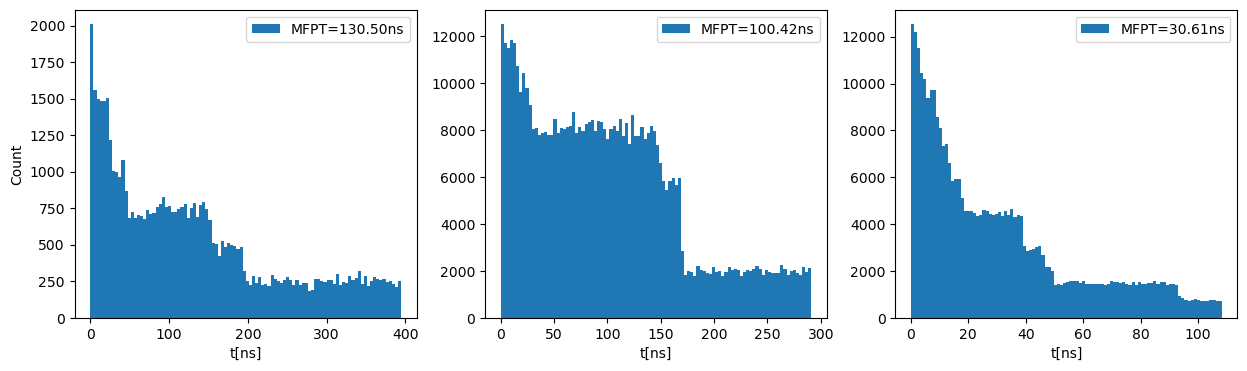

In [61]:
DT = 0.1 # ps
# md_DT = 1 
# md_x_main = np.load('alanine_depeptide/data/traj_1ps.npy')[:, 0]
# x_list= np.load('alanine_depeptide/GLE_data/gle_traj_DT100fs_fit2ps.npy')
# gle_x_main =  (x_list @ th2np(eigM.T))[:,0]
le_x_list= np.load('alanine_depeptide/GLE_data/le_traj_DT100fs_tau1ps.npy')
le_x_main =  (le_x_list @ th2np(eigM.T))[:,0]

start = -1.5
end = 1
# end_idx, gle_fpt = mfpt(gle_x_main , start, end) 
# gle_fpt = gle_fpt.astype(float) * DT / 1000
end_idx, le_fpt = mfpt(le_x_main , start, end) 
le_fpt = le_fpt.astype(float) * DT / 1000
# end_idx, md_fpt = mfpt(md_x_main , start, end) 
# md_fpt = md_fpt.astype(float) * md_DT / 1000

fig,ax = plt.subplots(1,3, figsize= (15,4))
ax[0].hist(md_fpt, 100, label='MFPT={:.2f}ns'.format(md_fpt.mean()))
ax[0].set_xlabel('t[ns]')
ax[0].legend()
ax[0].set_ylabel('Count')

ax[1].hist(gle_fpt, 100, label='MFPT={:.2f}ns'.format(gle_fpt.mean()))
ax[1].set_xlabel('t[ns]')
ax[1].legend()

ax[2].hist(le_fpt, 100, label='MFPT={:.2f}ns'.format(le_fpt.mean()))
ax[2].set_xlabel('t[ns]')
ax[2].legend()

Text(0, 0.5, 'Count')

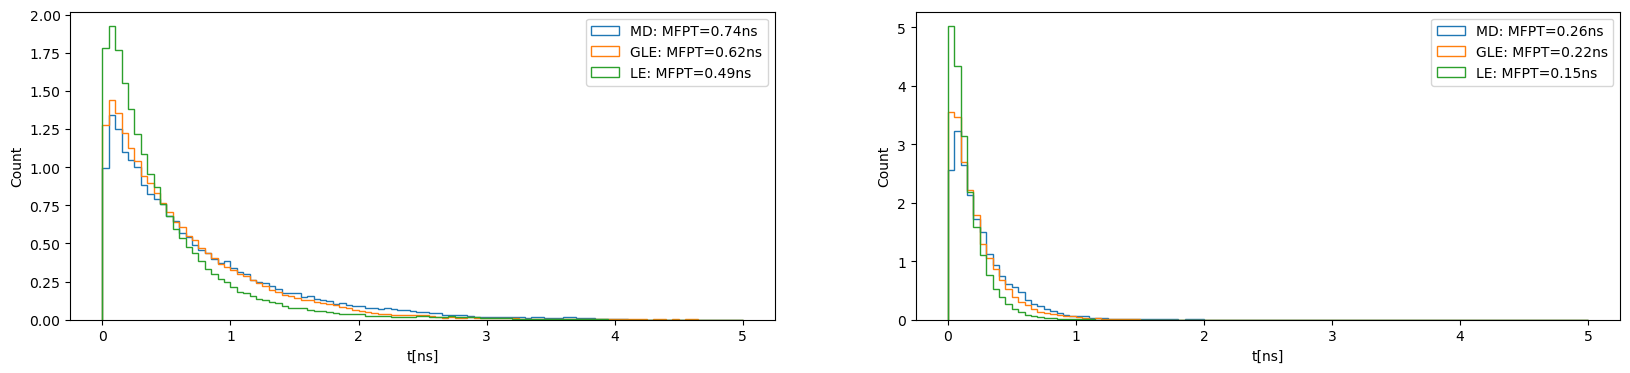

In [77]:
DT = 0.1 # ps
md_DT = 1 
md_x = mic(np.load('alanine_depeptide/data/traj_1ps.npy')) 

x_list= np.load('alanine_depeptide/GLE_data/gle_traj_DT100fs_fit50ps.npy')
gle_x =  mic((x_list @ th2np(eigM.T)))

le_x_list= np.load('alanine_depeptide/GLE_data/le_traj_DT100fs_fit50ps.npy')
le_x  =  mic((le_x_list @ th2np(eigM.T)))

left1 = np.array([ -1.25, 2.5,])
left2 = np.array([ -1.25, -0.5,])
right1 = np.array([ 1, 0.5])

start = left1
end = left2

end_idx, gle_fpt = mfpt(gle_x , start, end, 0.2) 
gle_fpt = gle_fpt.astype(float) * DT / 1000

end_idx, le_fpt = mfpt(le_x , start, end, 0.2) 
le_fpt = le_fpt.astype(float) * DT / 1000

end_idx, md_fpt = mfpt(md_x , start, end, 0.2) 
md_fpt = md_fpt.astype(float) * md_DT / 1000

fig,ax = plt.subplots(1,2, figsize= (20,4))
ax[0].hist(md_fpt, 100, density=True, label='MD: MFPT={:.2f}ns'.format(md_fpt.mean()), alpha=1, range = (0,5), histtype='step')
ax[0].hist(gle_fpt, 100, density=True, label='GLE: MFPT={:.2f}ns'.format(gle_fpt.mean()), alpha=1, range = (0,5), histtype='step')
ax[0].hist(le_fpt, 100, density=True, label='LE: MFPT={:.2f}ns'.format(le_fpt.mean()), alpha=1, range = (0,5), histtype='step')
ax[0].set_xlabel('t[ns]')
ax[0].legend()
ax[0].set_ylabel('Count')

start = left2
end = left1

end_idx, gle_fpt = mfpt(gle_x , start, end, 0.2) 
gle_fpt = gle_fpt.astype(float) * DT / 1000

end_idx, le_fpt = mfpt(le_x , start, end, 0.2) 
le_fpt = le_fpt.astype(float) * DT / 1000

end_idx, md_fpt = mfpt(md_x , start, end, 0.2) 
md_fpt = md_fpt.astype(float) * md_DT / 1000

ax[1].hist(md_fpt, 100, density=True, label='MD: MFPT={:.2f}ns'.format(md_fpt.mean()), alpha=1, range = (0,2.5), histtype='step')
ax[1].hist(gle_fpt, 100, density=True, label='GLE: MFPT={:.2f}ns'.format(gle_fpt.mean()), alpha=1, range = (0,2.5), histtype='step')
ax[1].hist(le_fpt, 100, density=True, label='LE: MFPT={:.2f}ns'.format(le_fpt.mean()), alpha=1, range = (0,2.5), histtype='step')
ax[1].set_xlabel('t[ns]')
ax[1].legend()
ax[1].set_ylabel('Count')


Text(0, 0.5, 'Count')

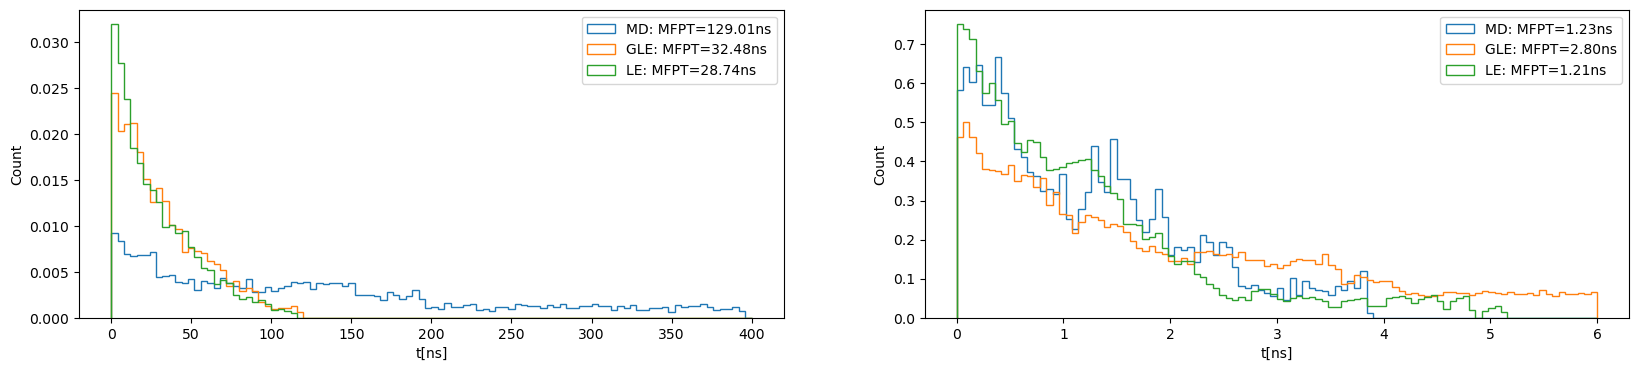

In [7]:
DT = 0.1 # ps
md_DT = 1 
md_x = mic(np.load('alanine_depeptide/data/traj_1ps.npy')) 

x_list= np.load('alanine_depeptide/GLE_data/gle_traj_DT100fs_fit2ps.npy')
gle_x =  mic((x_list @ th2np(eigM.T)))

le_x_list= np.load('alanine_depeptide/GLE_data/le_traj_DT100fs_fit50ps.npy')
le_x  =  mic((le_x_list @ th2np(eigM.T)))

left1 = np.array([ -1.25, 2.5,])
left2 = np.array([ -1.25, -0.5,])
right1 = np.array([ 1, 0.5])

start = left1
end = right1

end_idx, gle_fpt = mfpt(gle_x , start, end, 0.2) 
gle_fpt = gle_fpt.astype(float) * DT / 1000

end_idx, le_fpt = mfpt(le_x , start, end, 0.2) 
le_fpt = le_fpt.astype(float) * DT / 1000

end_idx, md_fpt = mfpt(md_x , start, end, 0.2) 
md_fpt = md_fpt.astype(float) * md_DT / 1000

fig,ax = plt.subplots(1,2, figsize= (20,4))
ax[0].hist(md_fpt, 100, density=True, label='MD: MFPT={:.2f}ns'.format(md_fpt.mean()), alpha=1, range = (0,400), histtype='step')
ax[0].hist(gle_fpt, 100, density=True, label='GLE: MFPT={:.2f}ns'.format(gle_fpt.mean()), alpha=1, range = (0,400), histtype='step')
ax[0].hist(le_fpt, 100, density=True, label='LE: MFPT={:.2f}ns'.format(le_fpt.mean()), alpha=1, range = (0,400), histtype='step')
ax[0].set_xlabel('t[ns]')
ax[0].legend()
ax[0].set_ylabel('Count')

start = right1
end = left1

end_idx, gle_fpt = mfpt(gle_x , start, end, 0.2) 
gle_fpt = gle_fpt.astype(float) * DT / 1000

end_idx, le_fpt = mfpt(le_x , start, end, 0.2) 
le_fpt = le_fpt.astype(float) * DT / 1000

end_idx, md_fpt = mfpt(md_x , start, end, 0.2) 
md_fpt = md_fpt.astype(float) * md_DT / 1000

ax[1].hist(md_fpt, 100, density=True, label='MD: MFPT={:.2f}ns'.format(md_fpt.mean()), alpha=1, range = (0,6), histtype='step')
ax[1].hist(gle_fpt, 100, density=True, label='GLE: MFPT={:.2f}ns'.format(gle_fpt.mean()), alpha=1, range = (0,6), histtype='step')
ax[1].hist(le_fpt, 100, density=True, label='LE: MFPT={:.2f}ns'.format(le_fpt.mean()), alpha=1, range = (0,6), histtype='step')
ax[1].set_xlabel('t[ns]')
ax[1].legend()
ax[1].set_ylabel('Count')


## MFPT old

In [10]:
MD_mfpt = np.array([[0.0000e+00, 4.9031e-02, 2.3586e-02, 1.7072e-02, 1.3138e-02,
        1.2099e-02, 1.7183e-02, 4.6013e-02, 3.2454e-01, 5.0031e+00,
        8.7570e+01, 1.7146e+02, 2.4132e+02, 1.6158e+02, 2.7040e+02,
        3.8918e+02, 2.1367e+02, 1.0580e+02, 1.0575e+02, 9.3982e+01],
       [1.6426e+00, 1.5576e+00, 1.5122e+00, 1.4740e+00, 1.4701e+00,
        1.4666e+00, 1.4684e+00, 1.4960e+00, 1.6430e+00, 5.8514e+00,
        1.3662e+02, 8.9514e+01, 1.9643e+02, 1.9664e+02, 1.2886e+02,
        3.7676e+02, 1.3885e+02, 4.7517e+00, 5.1456e-01, 0.0000e+00]])

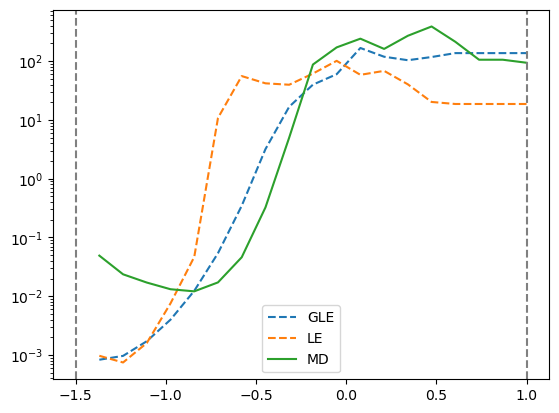

In [20]:
 
from mftp import calc_mfpt

n_points = 20
start=-1.5
end=1
milestones = np.linspace(start, end, n_points)
mfpt, mfpt_err = calc_mfpt( x_main , start=start, end=end, n_points=n_points, dt=DT/1000)
mfpt_le, mfpt_le_err = calc_mfpt( le_x_main , start=start, end=end, n_points=n_points, dt=DT/1000)

fig,ax=plt.subplots()
ax.semilogy(milestones[1:], mfpt[0][1:], linestyle='dashed', label='GLE')
# ax.semilogy(milestones[:-1], mfpt[1][:-1], linestyle='dashed', label='GLE')
ax.semilogy(milestones[1:], mfpt_le[0][1:], linestyle='dashed', label='LE')
# ax.semilogy(milestones[:-1], mfpt_le[1][:-1], linestyle='dashed', label='LE')
ax.semilogy(milestones[1:], MD_mfpt[0][1:], label='MD')
# ax.semilogy(milestones[:-1], MD_mfpt[1][:-1], label='MD' )
# ax.plot(milestones[1:], mfpt[0][1:])
# ax.plot(milestones[:-1], mfpt[1][:-1], linestyle='dashed')

ax.legend()
ax.axvline(start, linestyle='dashed', color='grey')
ax.axvline(end, linestyle='dashed', color='grey')

